# Self-Driving Car Engineer Nanodegree

## Project: **Advanced Lane Finding Project**

Tasks:

1) Camera calibration using chessboard images

2) Undistort image streams from a car-attached camera

3) Make a binary threshold file using Gradients and different color channels

4) Transform the image to bird-s eye view

5) Detect lane pixels using histograms and fit a polynomial of second degree each.

6) Warp the detected lane boundaries back to original.

7) Show detection results visually

## Import necessary libraries

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

## Get Calibration Parameters

In [25]:
def calibrateCamera(checker_folder, show_image):
    objpoints=[]
    imgpoints=[]
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    
    checker_imgs = os.listdir(checker_folder)
    checker_img_size = []
    
    for checker_img_path in checker_imgs:
        checker_img = cv2.imread(checker_folder + "/" + checker_img_path)
        checker_gray = cv2.cvtColor(checker_img,cv2.COLOR_BGR2GRAY)
        
        checker_img_size = (checker_img.shape[1], checker_img.shape[0])
    
        ret, checker_corners = cv2.findChessboardCorners(checker_gray, (9,6),None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(checker_corners)
            if show_image == True:
                img = cv2.drawChessboardCorners(checker_img, (9,6), checker_corners, ret)
                plt.figure()
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, checker_img_size,None,None)
    
    return mtx, dist
    

## Undistort images using calibration parameters

In [26]:
def undistort_image(image, mtx, dist, show_image):
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    if show_image == True:
        f, (a1, a2) = plt.subplots(1, 2, figsize=(24, 9))
        #f.tight_layout()
        a1.imshow(np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
        a1.set_title('Original Image')
        a2.imshow(np.array(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB)))
        a2.set_title('Undistorted Image')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return undistorted_image

## Apply Gradient Thresholding

In [27]:
def gradient_axis_thresholding(image, axis, limits=(20,100)):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= limits[0]) &(scaled_sobel <= limits[1])] = 1
    return binary_sobel

def gradient_abs_thresholding(image, sobel_kernel=3, mag_thresh=(30, 100)):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def gradient_dir_thresholding(image, sobel_kernel=3, dir_thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    return binary_output

def gradient_thresholding(image, limits=(20,100), mag_sobel_kernel=3, mag_thresh=(30, 100), dir_sobel_kernel=3, dir_thresh=(0.7, 1.3)):
    sobel_x = gradient_axis_thresholding(image, 'x', limits)
    sobel_y = gradient_axis_thresholding(image, 'y', limits)
    sobel_abs = gradient_abs_thresholding(image, mag_sobel_kernel, mag_thresh)
    sobel_dir = gradient_dir_thresholding(image, dir_sobel_kernel, dir_thresh)
    binary_output = np.zeros_like(sobel_dir)
    binary_output[((sobel_x ==1 ) & (sobel_y == 1)) | ((sobel_abs ==1 ) & (sobel_dir == 1))] = 1
    return binary_output

## Apply Color Thresholding and Make a binary threshold image

In [28]:
def color_thresholding(image, limits=(170, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= limits[0]) & (s_channel <= limits[1])] = 1
    return s_binary

def thresholding(image, limits=(20,100), mag_sobel_kernel=3, mag_thresh=(30, 100), dir_sobel_kernel=3, dir_thresh=(0.7, 1.3), color_thresh = (170, 255), show_image = True):
    s_gradient_binary = gradient_thresholding(image, limits, mag_sobel_kernel, mag_thresh, dir_sobel_kernel, dir_thresh)
    s_color_binary = color_thresholding(image, color_thresh)
    s_binary = np.zeros_like(s_color_binary)
    s_binary[(s_gradient_binary == 1) | (s_color_binary == 1)] = 1
    if show_image == True:
        f, (a1, a2) = plt.subplots(1, 2, figsize=(24, 9))
        #f.tight_layout()
        a1.imshow(np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
        a1.set_title('Original Image')
        a2.imshow(s_binary)
        a2.set_title('Threshold Image')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return s_binary

## Create basic histograms out of binary threshold images

In [29]:
def histogram_maker(warped, show_image=True):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    if show_image == True:
        plt.plot(histogram)
        
    out_img = np.dstack((warped, warped, warped))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram, leftx_base, rightx_base

## Define a pipeline process for the camera calibration and the image warping
## Test this pipeline with images

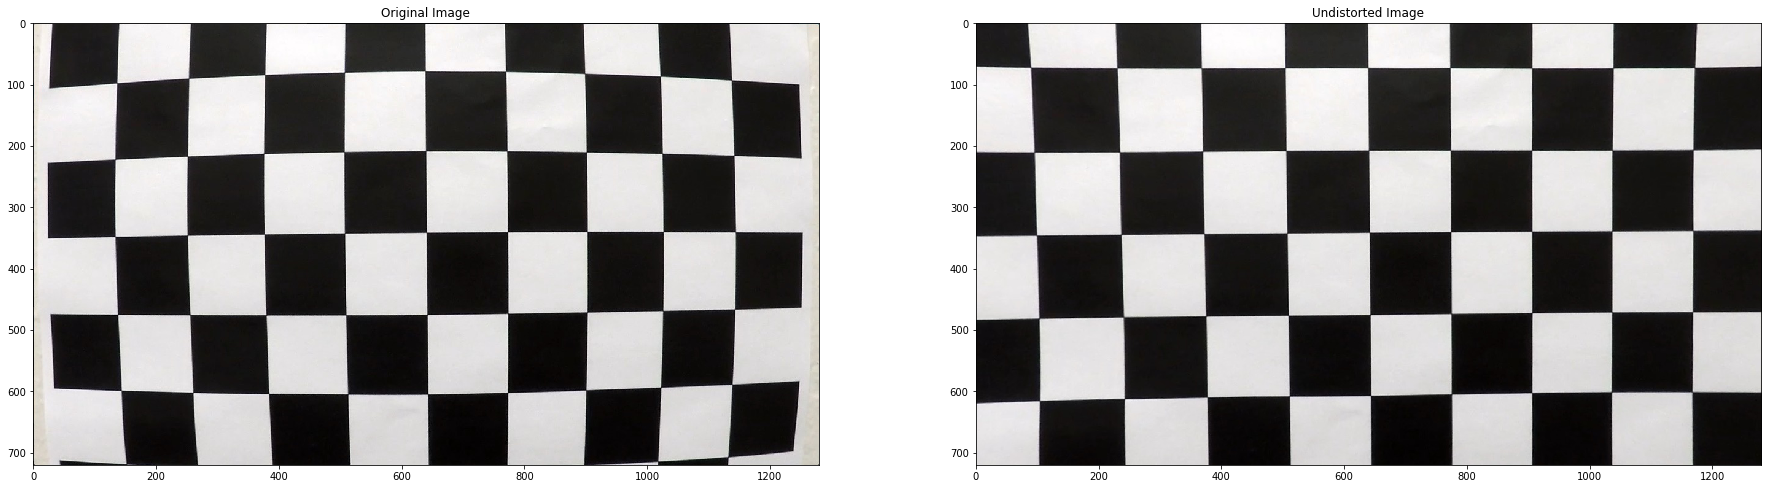

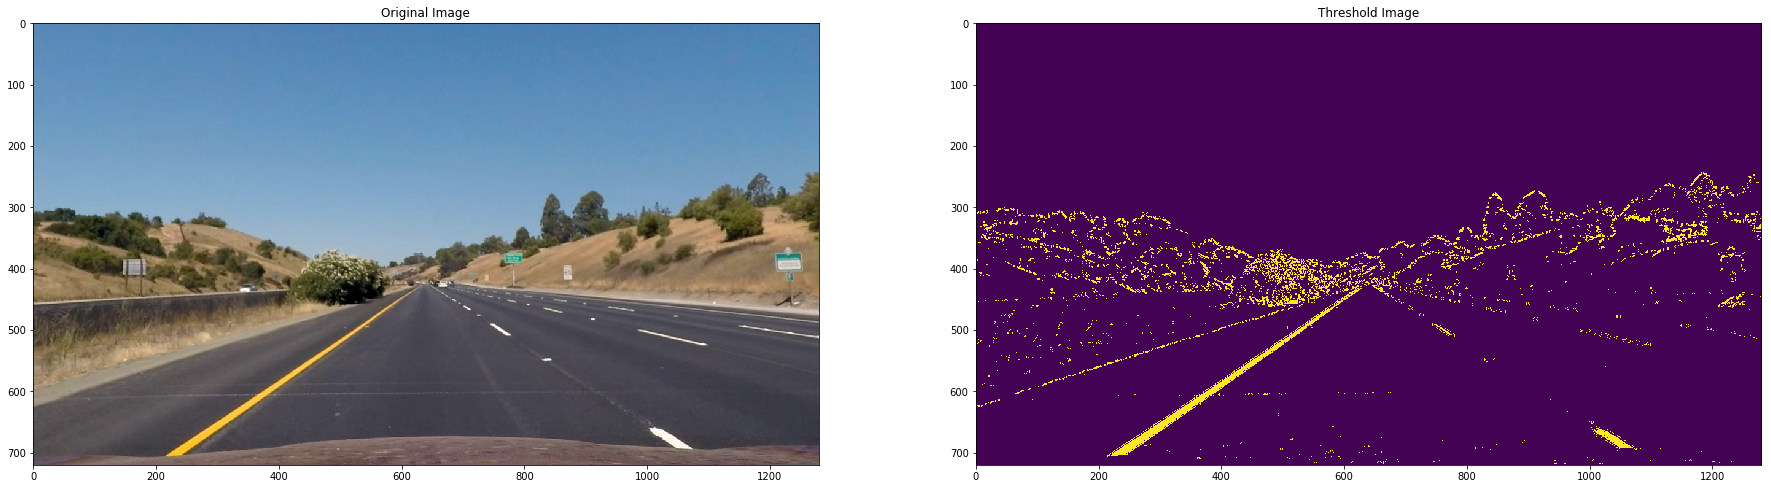

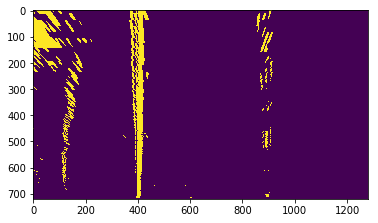

In [30]:
def pipelineForCalibrationAndWarping(imagePathToWarp, show_images):
    mtx, dist = calibrateCamera("./camera_cal", False)
    distorted_img = cv2.imread("./camera_cal/calibration1.jpg")
    undistorted_img = undistort_image(distorted_img, mtx, dist, show_images)
    warped, _ = pipelineForWarping(imagePathToWarp, mtx, dist, True, show_images)
    return warped, mtx, dist
    
def pipelineForWarping(image, mtx, dist, isPath, show_images):
    if(isPath == True):
        distorted_lane_img = cv2.imread(image)
    else:
        distorted_lane_img = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        
    undistorted_lane_img = undistort_image(distorted_lane_img, mtx, dist, False)
    thresholded_lane_img = thresholding(undistorted_lane_img, show_image = show_images)
    
    offset = 100
    img_size = (thresholded_lane_img.shape[1], thresholded_lane_img.shape[0])
    
    #src = np.float32([[210,700],[580,460], [1080, 700], [680,460]])
    #src = np.float32([[210,700],[580,460], [1080, 700], [700,460]])
    #dst = np.float32([[offset, img_size[1]-offset], [offset, offset], 
    #                  [img_size[0]-offset, img_size[1]-offset], [img_size[0]-offset, offset]])
    
    y_bottom = 720
    y_top = 450
    src_x1 = 240 #bottom left
    src_x2 = 1040 #bottom right
    src_x3 = 600 #top left
    src_x4 = 680 #top right

    shrink_base_factor = 0.55

    dest_x1 = src_x1 + (src_x2 - src_x1) * (1- shrink_base_factor) / 2
    dest_x2 = src_x2 - (src_x2 - src_x1) * (1- shrink_base_factor) / 2

    src = np.float32([[src_x1,y_bottom],[src_x2,y_bottom],[src_x3,y_top],[src_x4,y_top]])
    dst = np.float32([[dest_x1,y_bottom],[dest_x2,y_bottom],[dest_x1,0],[dest_x2,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    M_reverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(thresholded_lane_img, M, img_size)
    
    if(show_images):
        plt.figure()
        plt.imshow(warped)
    
    if(isPath == True):
        base=os.path.splitext(os.path.basename(image))[0]
        result=cv2.imwrite("output_images/"+ base + "_warped.jpg", 255* warped)
        result1=cv2.imwrite("output_images/"+ base + "_thresholded.jpg", 255* thresholded_lane_img)
        result2=cv2.imwrite("output_images/"+ base + "_undistorted.jpg", undistorted_lane_img)
    
    return warped, M_reverse

warped, mtx, dist = pipelineForCalibrationAndWarping("./test_images/straight_lines1.jpg", True)
_, _ = pipelineForWarping("./test_images/straight_lines2.jpg", mtx, dist, True, False)
_, _ = pipelineForWarping("./test_images/test1.jpg", mtx, dist, True, False)
_, _ = pipelineForWarping("./test_images/test2.jpg", mtx, dist, True, False)
_, _ = pipelineForWarping("./test_images/test3.jpg", mtx, dist, True, False)
_, _ = pipelineForWarping("./test_images/test4.jpg", mtx, dist, True, False)
_, _ = pipelineForWarping("./test_images/test5.jpg", mtx, dist, True, False)
_, _ = pipelineForWarping("./test_images/test6.jpg", mtx, dist, True, False)

## Test Histogram Maker

(array([4, 4, 6, ..., 0, 0, 0], dtype=uint64), 400, 894)

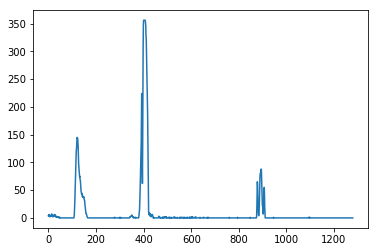

In [31]:
histogram_maker(warped)

## Define the process of finding lane pixels and fitting a curve to lane pixels using window approach

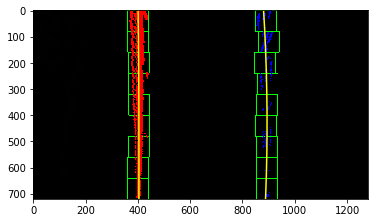

In [39]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 40
    minpix = 40

    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def window_maker(binary_warped, show_image=True):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    if (show_image == True):
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

windows, _, _ = window_maker(warped)
plt.imshow(windows)
result=cv2.imwrite("output_images/straight_lines1_windows.jpg", windows)

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.frame_counter = 0
        self.consecutive_detection_counter = 0
        self.consecutive_undetection_counter = 0

## Helper Functions for measuring lane curvatures and displaying info over images

In [34]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measure_curvature_real(image, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = image.shape[1]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    
    return left_curverad, right_curverad

def display_text_over_image(img,curvature,distance):

    cv2.putText(
        img,
        'Curvature (Avg L+R):' + str(curvature) + 'm', 
        (200,75), 
        cv2.FONT_HERSHEY_DUPLEX, 
        1, 
        (255, 0, 0, 255), #font color
        3)
    
    cv2.putText(
        img,
        'Distance to center:' + str(distance) + 'm', 
        (200,125), 
        cv2.FONT_HERSHEY_DUPLEX, 
        1, 
        (0, 0, 255, 255), #font color
        3)
    
    return img

## Lane finding by making use of  lane pixels of previous frames

In [35]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def sanity_checker(left_inds_size, right_inds_size, left_fitx, right_fitx, curve_left, curve_right):
    min_pixel_detected = (left_inds_size > 15000) and (right_inds_size > 15000)
    similar_curvature = abs(curve_left - curve_right) < 500 * 720 / 30
    min_distance_btw_lines = (350 < (right_fitx[359] - left_fitx[359]) < 650)
    parallel_value = abs((right_fitx[0] - left_fitx[0]) - (right_fitx[719] - left_fitx[719]))
    parallelism = parallel_value < 80
    return (min_pixel_detected & similar_curvature & min_distance_btw_lines & parallelism)

def window_maker_feed_forward(binary_warped, M_reverse, left_lane, right_lane, show_image=False):
    left_lane.frame_counter += 1
    right_lane.frame_counter += 1
    margin = 40
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_lane.current_fit[0]*(nonzeroy**2) + left_lane.current_fit[1]*nonzeroy + 
                    left_lane.current_fit[2] - margin)) & (nonzerox < (left_lane.current_fit[0]*(nonzeroy**2) + 
                    left_lane.current_fit[1]*nonzeroy + left_lane.current_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_lane.current_fit[0]*(nonzeroy**2) + right_lane.current_fit[1]*nonzeroy + 
                    right_lane.current_fit[2] - margin)) & (nonzerox < (right_lane.current_fit[0]*(nonzeroy**2) + 
                    right_lane.current_fit[1]*nonzeroy + right_lane.current_fit[2] + margin)))
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if(nonzerox[left_lane_inds].size != 0 and nonzeroy[left_lane_inds].size != 0 and nonzerox[right_lane_inds].size != 0 and nonzeroy[right_lane_inds].size != 0):
        left_lane.allx = nonzerox[left_lane_inds]
        left_lane.ally = nonzeroy[left_lane_inds] 
        right_lane.allx = nonzerox[right_lane_inds]
        right_lane.ally = nonzeroy[right_lane_inds]
        
    
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, left_lane.allx, left_lane.ally, right_lane.allx, right_lane.ally)
    
    
    left_fit_cr = np.polyfit(left_lane.ally*ym_per_pix, left_lane.allx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_lane.ally*ym_per_pix, right_lane.allx*xm_per_pix, 2)
    curve_left, curve_right = measure_curvature_real(binary_warped, left_fit_cr, right_fit_cr) 
    sanity_check = sanity_checker(len(left_lane_inds), len(right_lane_inds),left_fitx, right_fitx, curve_left, curve_right)#, left_fit, right_fit)
    
    if (sanity_check == True):     
        left_lane.detected = True
        right_lane.detected = True
        left_lane.recent_xfitted.append(left_fitx)
        right_lane.recent_xfitted.append(right_fitx)
        left_lane.current_fit = left_fit
        right_lane.current_fit = right_fit
        left_lane.radius_of_curvature = curve_left
        right_lane.radius_of_curvature = curve_right
        if(left_lane.best_fit == None):
            left_lane.best_fit = left_lane.current_fit
        else:
            left_lane.best_fit = (left_lane.best_fit * left_lane.consecutive_detection_counter + left_lane.current_fit) / (left_lane.consecutive_detection_counter + 1) 
        if(right_lane.best_fit == None):
            right_lane.best_fit = right_lane.current_fit
        else:
            right_lane.best_fit = (right_lane.best_fit * right_lane.consecutive_detection_counter + right_lane.current_fit) / (right_lane.consecutive_detection_counter + 1) 
        left_lane.consecutive_detection_counter += 1
        right_lane.consecutive_detection_counter += 1
        left_lane.consecutive_undetection_counter = 0
        right_lane.consecutive_undetection_counter = 0
    else:
        left_lane.detected = False
        right_lane.detected = False
        if(len(left_lane.recent_xfitted) > 0):
            left_fitx = left_lane.recent_xfitted[len(left_lane.recent_xfitted) - 1]
            right_fitx = right_lane.recent_xfitted[len(right_lane.recent_xfitted) - 1]
        left_lane.recent_xfitted = [left_fitx]
        right_lane.recent_xfitted = [right_fitx]
        left_lane.best_fit = np.zeros_like(left_lane.current_fit)
        right_lane.best_fit = np.zeros_like(right_lane.current_fit)
        left_lane.consecutive_detection_counter = 0
        right_lane.consecutive_detection_counter = 0
        left_lane.consecutive_undetection_counter += 1
        right_lane.consecutive_undetection_counter += 1
        
    left_lane.bestx = np.array(left_lane.recent_xfitted).mean(axis=0)
    left_lane.line_base_pos = left_lane.bestx[0]
    right_lane.bestx = np.array(right_lane.recent_xfitted).mean(axis=0)
    right_lane.line_base_pos = right_lane.bestx[0]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if (show_image == True):
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
    img_size = (out_img.shape[1], out_img.shape[0])
    unwarped_img = cv2.warpPerspective(result, M_reverse, img_size)
    
    return unwarped_img#, left_fit, right_fit

## Define whole lane finding pipeline for videos

In [36]:
def video_pipeline(in_path = 'project_video.mp4', out_path = 'output_images/project_video.mp4'):
    
    clip = VideoFileClip(in_path)
    frames = int(clip.fps * clip.duration)
    initial_warp, _ = pipelineForWarping(clip.get_frame(3), mtx, dist, False, False)
    _, left_fit, right_fit = window_maker(initial_warp, show_image = False)
        
    left_lane = Line()
    right_lane = Line()
    
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit    
    processed_images = []
    for i in range(0, frames):
        image = clip.get_frame(i/clip.fps)
        warp, M_reverse =  pipelineForWarping(image, mtx, dist, False, False)
        image_with_path = window_maker_feed_forward(warp, M_reverse, left_lane, right_lane)
        result = cv2.addWeighted(image, 1, image_with_path, 0.3, 0)
        curvature = left_lane.radius_of_curvature
        distance = round((640 - (left_lane.line_base_pos + right_lane.line_base_pos) / 2) * xm_per_pix,2)
        result = display_text_over_image(result,curvature,distance)
        processed_images.append(result)
    clip = ImageSequenceClip(processed_images, fps=clip.fps)
    clip.write_videofile(out_path, audio=False)
    

As I go to each frame manually by get_frame function, the video pipeline below is a bit slow!

In [37]:
video_pipeline()

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|██████████| 1260/1260 [01:59<00:00, 11.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 



In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_images/project_video.mp4'))

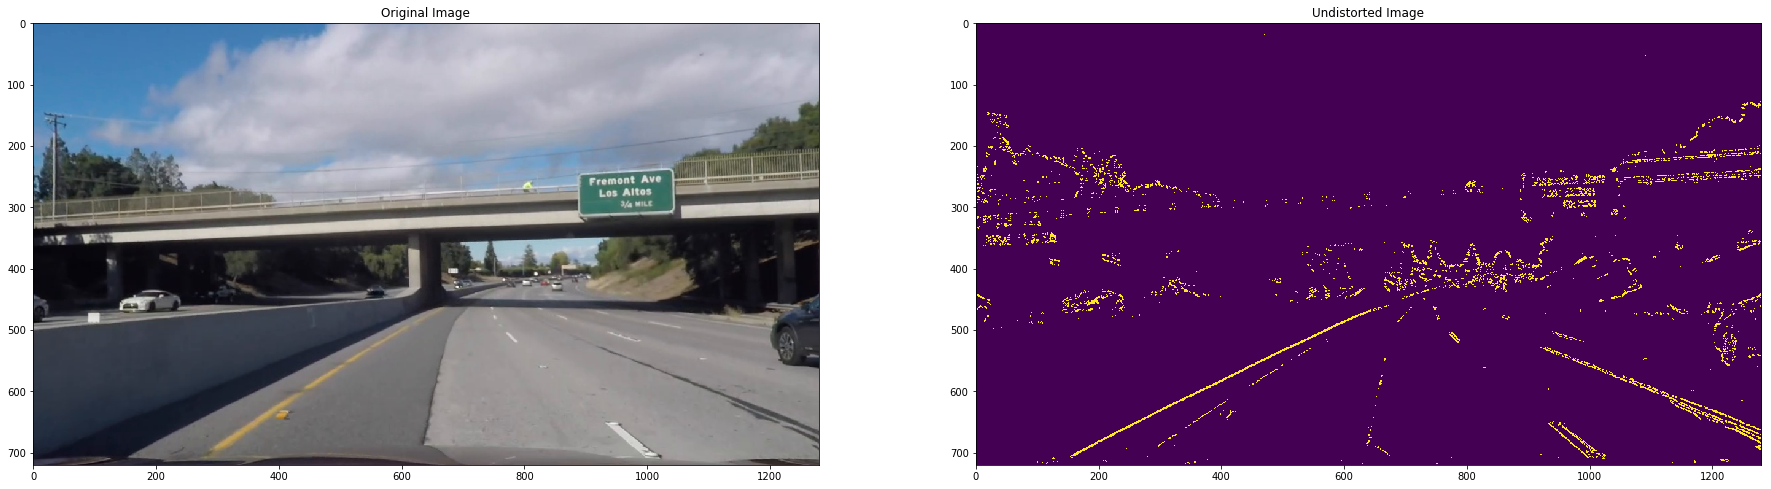

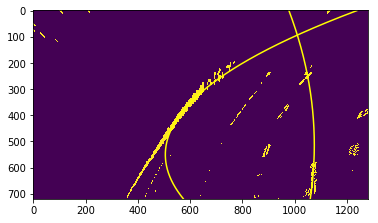

In [73]:
video_pipeline(in_path = 'challenge_video.mp4', out_path = 'output_images/challenge_video.mp4')